In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col = 0)

In [3]:
checkpoint = torch.load("../test/Brian/nov22_test01/final/checkpoint_final.tar")
demo_df = pd.read_csv("../split_datasets/live_demo.csv")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")
demo_df = demo_df.drop(columns="amenities")

In [4]:
#Number accomodates vs price
#Number of bathrooms and bedrooms vs price
demo_df

,host_is_superhost,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,amenities_count,facilities_Free parking on premises,facilities_Gym,facilities_Hot tub,facilities_Pool,facilities_count,house_rules_Suitable for events,house_rules_Pets allowed,house_rules_Smoking allowed,house_rules_count
0,0,-0.881203,-0.896103,-0.061014,1.182045,1.329375,-1.165452,0.652325,-0.353343,-0.650700,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
1,0,0.145206,-0.333142,0.222818,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,-0.427262,0,0,0,0,-0.901841,0,0,0,-0.410572
2,0,-1.042496,1.851645,1.795044,-0.986725,1.329375,-0.597957,-0.436242,-0.353343,-0.650700,...,-0.427262,0,0,0,0,-0.901841,0,0,0,-0.410572
3,1,-0.617269,2.360930,0.983627,-0.444532,-0.686927,1.104526,0.652325,0.953672,0.389812,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
4,1,0.541107,-0.491634,-1.055418,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
5,0,-0.455976,-0.276603,-2.584298,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572
6,1,-0.807888,-0.351967,-0.797598,2.266429,-0.686927,-0.597957,-0.436242,-1.660357,-0.650700,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
7,0,-0.734573,0.303578,-1.091032,-1.528917,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572
8,0,3.371063,0.751704,0.044698,0.097660,-0.686927,1.672021,5.006591,2.260687,1.430323,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
9,1,-0.236032,-0.684738,0.100713,1.182045,3.345677,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572


In [5]:
test_df

,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,amenities_count,facilities_Free parking on premises,facilities_Gym,facilities_Hot tub,facilities_Pool,facilities_count,house_rules_Suitable for events,house_rules_Pets allowed,house_rules_Smoking allowed,house_rules_count
0,0,-0.790334,0.371405,-0.444532,1.329375,-0.597957,0.652325,-0.353343,-0.650700,-0.294683,...,-2.228663,1,1,0,1,1.638226,0,0,0,-0.410572
1,0,-0.122362,0.210520,-0.444532,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,0.306499,...,1.013858,0,0,0,0,-0.901841,0,0,0,-0.410572
2,0,-0.139712,0.227703,-0.444532,1.329375,-0.597957,-0.436242,-0.353343,-0.650700,-0.221369,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
3,0,-0.713994,-0.104175,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,0.365151,...,0.293298,0,1,1,1,1.638226,0,0,0,-0.410572
4,0,-0.972291,0.710358,-0.986725,-0.686927,1.104526,-0.436242,0.953672,1.430323,2.637913,...,-0.427262,0,0,0,0,-0.901841,0,1,0,1.813424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20956,0,-0.890351,-1.215479,1.182045,-0.686927,-0.030463,0.652325,-0.353343,0.389812,0.438466,...,-0.066982,1,1,0,1,1.638226,0,1,0,1.813424
20957,0,0.731824,-0.784213,-1.528917,-0.686927,0.537032,-0.436242,0.953672,0.389812,-0.367998,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
20958,0,-0.163516,0.085236,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,1.538190,...,-1.147823,0,0,0,0,-0.901841,0,0,0,-0.410572
20959,0,0.963121,-1.000366,1.182045,-0.686927,0.537032,-0.436242,-0.353343,0.389812,-0.030750,...,-0.427262,1,0,0,0,-0.055152,0,1,0,1.813424


In [7]:
print(max( (test_df["accommodates"]*mean_std["std"]["accommodates"]) + mean_std["mean"]["accommodates"]))
print(min( test_df["accommodates"]*mean_std["std"]["accommodates"] + mean_std["mean"]["accommodates"]))

15.999999999999998
1.0000000000000004


In [310]:
accommodates = ((test_df["accommodates"]*mean_std["std"]["accommodates"]) + mean_std["mean"]["accommodates"]).tolist()
price = ((test_df["price"]*mean_std["std"]["price"]) + mean_std["mean"]["price"]).tolist()

In [313]:
accommodates = [float(round(i)) for i in accommodates]
#accommodates

In [322]:
myset = set(accommodates)
mynewlist = list(myset)
print(mynewlist.sort())
print(mynewlist)
accommodates_to_plot = mynewlist

None
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]


In [321]:
d = {'price': price, 'accomodates': accommodates}
new_test_df = pd.DataFrame(data=d)
print(len(new_test_df))

20961


In [331]:
num_of_samples = [0 for i in range(0, len(accommodates_to_plot))]
price_to_plot = [0 for i in range(0, len(accommodates_to_plot))]
for i in range(0, len(new_test_df)):
    for k in range(0, len(accommodates_to_plot)):
        if (new_test_df['accomodates'][i] == accommodates_to_plot[k]):
            num_of_samples[k] += 1
            price_to_plot[k] += new_test_df['price'][i]

print(num_of_samples)
print(price_to_plot)
for l in range(0, len(accommodates_to_plot)):
    price_to_plot[l] = float(price_to_plot[l])/float(num_of_samples[l])
    
print('after', price_to_plot)

[2232, 9002, 2529, 4055, 1044, 1313, 225, 347, 52, 86, 16, 26, 4, 8, 3, 19]
[145595.0, 872469.0, 322156.0, 590575.0, 181638.0, 238398.0, 44704.0, 74721.0, 11107.0, 19584.0, 3900.0, 6304.0, 616.0, 2343.0, 371.0, 3624.0]
after [65.23073476702508, 96.91946234170184, 127.38473705021748, 145.64118372379778, 173.98275862068965, 181.56740289413557, 198.68444444444444, 215.3342939481268, 213.59615384615384, 227.72093023255815, 243.75, 242.46153846153845, 154.0, 292.875, 123.66666666666667, 190.73684210526315]


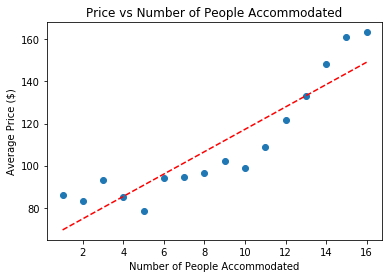

In [352]:
plt.scatter(accommodates_to_plot, price_to_plot)
plt.xlabel("Number of People Accommodated")
plt.ylabel("Average Price ($)")
plt.title("Price vs Number of People Accommodated")
    
z = np.polyfit(accommodates_to_plot, price_to_plot, 1)
p = np.poly1d(z)
plt.plot(accommodates_to_plot, p(accommodates_to_plot),"r--")
    
plt.savefig("../live_demo/Price_vs_Number_of_People_Accommodated.png", dpi=300)

In [343]:
amenities_count = ((test_df["amenities_count"]*mean_std["std"]["amenities_count"]) + mean_std["mean"]["amenities_count"]).tolist()
price = ((test_df["price"]*mean_std["std"]["price"]) + mean_std["mean"]["price"]).tolist()

In [344]:
amenities_count = [float(round(i)) for i in amenities_count]
#accommodates

In [345]:
myset = set(amenities_count)
mynewlist = list(myset)
print(mynewlist.sort())
print(mynewlist)
amenities_to_plot = mynewlist[2:18]
print(amenities_to_plot)

None
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]
[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]


In [347]:
d = {'price': price, 'amenities_count': amenities_count}
new_test_df = pd.DataFrame(data=d)
print(len(new_test_df))

20961


In [349]:
num_of_samples = [0 for i in range(0, len(amenities_to_plot))]
price_to_plot = [0 for i in range(0, len(amenities_to_plot))]
for i in range(0, len(new_test_df)):
    for k in range(0, len(amenities_to_plot)):
        if (new_test_df['amenities_count'][i] == amenities_to_plot[k]):
            num_of_samples[k] += 1
            price_to_plot[k] += new_test_df['price'][i]

print(num_of_samples)
print(amenities_to_plot)
for l in range(0, len(amenities_to_plot)):
    price_to_plot[l] = float(price_to_plot[l])/float(num_of_samples[l])
    
print('after', price_to_plot)

[18, 46, 101, 171, 336, 611, 860, 1153, 1588, 2090, 2549, 3238, 3774, 3293, 806, 185]
[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
after [85.94444444444444, 83.21739130434783, 93.00990099009901, 85.14035087719299, 78.19642857142857, 94.28150572831424, 94.56976744186046, 96.50303555941024, 102.16687657430731, 98.78038277511962, 108.81639858768145, 121.74397776405188, 133.29146793852675, 148.2259337989675, 161.34615384615384, 163.4]


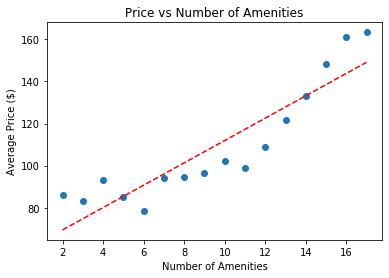

In [353]:
plt.scatter(amenities_to_plot, price_to_plot)
plt.xlabel("Number of Amenities")
plt.ylabel("Average Price ($)")
plt.title("Price vs Number of Amenities")
    
z = np.polyfit(amenities_to_plot, price_to_plot, 1)
p = np.poly1d(z)
plt.plot(amenities_to_plot, p(amenities_to_plot),"r--")
    
plt.savefig("../live_demo/Price_vs_Number_of_Amenities.png", dpi=300)

In [41]:
mean_std

,mean,std
price,120.097102,68.198942
latitude,43.677492,0.046110
longitude,-79.398326,0.059359
property_type,2.819879,1.844364
room_type,0.340686,0.495957
accommodates,3.053679,1.762132
bathrooms,1.200374,0.459320
bedrooms,1.270343,0.765102
beds,1.625366,0.961066
cancellation_policy,7.400940,5.685699


In [147]:
def get_error(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

# Property Type

In [ ]:
'''
    "House" : 1,
    "Apartment" : 2,
    "Condominium" : 5,
    "Townhouse" : 3,
    "Bungalow" : 0,
    "Loft" : 4,
    "Serviced apartment" : 6,
    "Guest suite" : 7
'''

None
[-4.440892098500626e-16, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


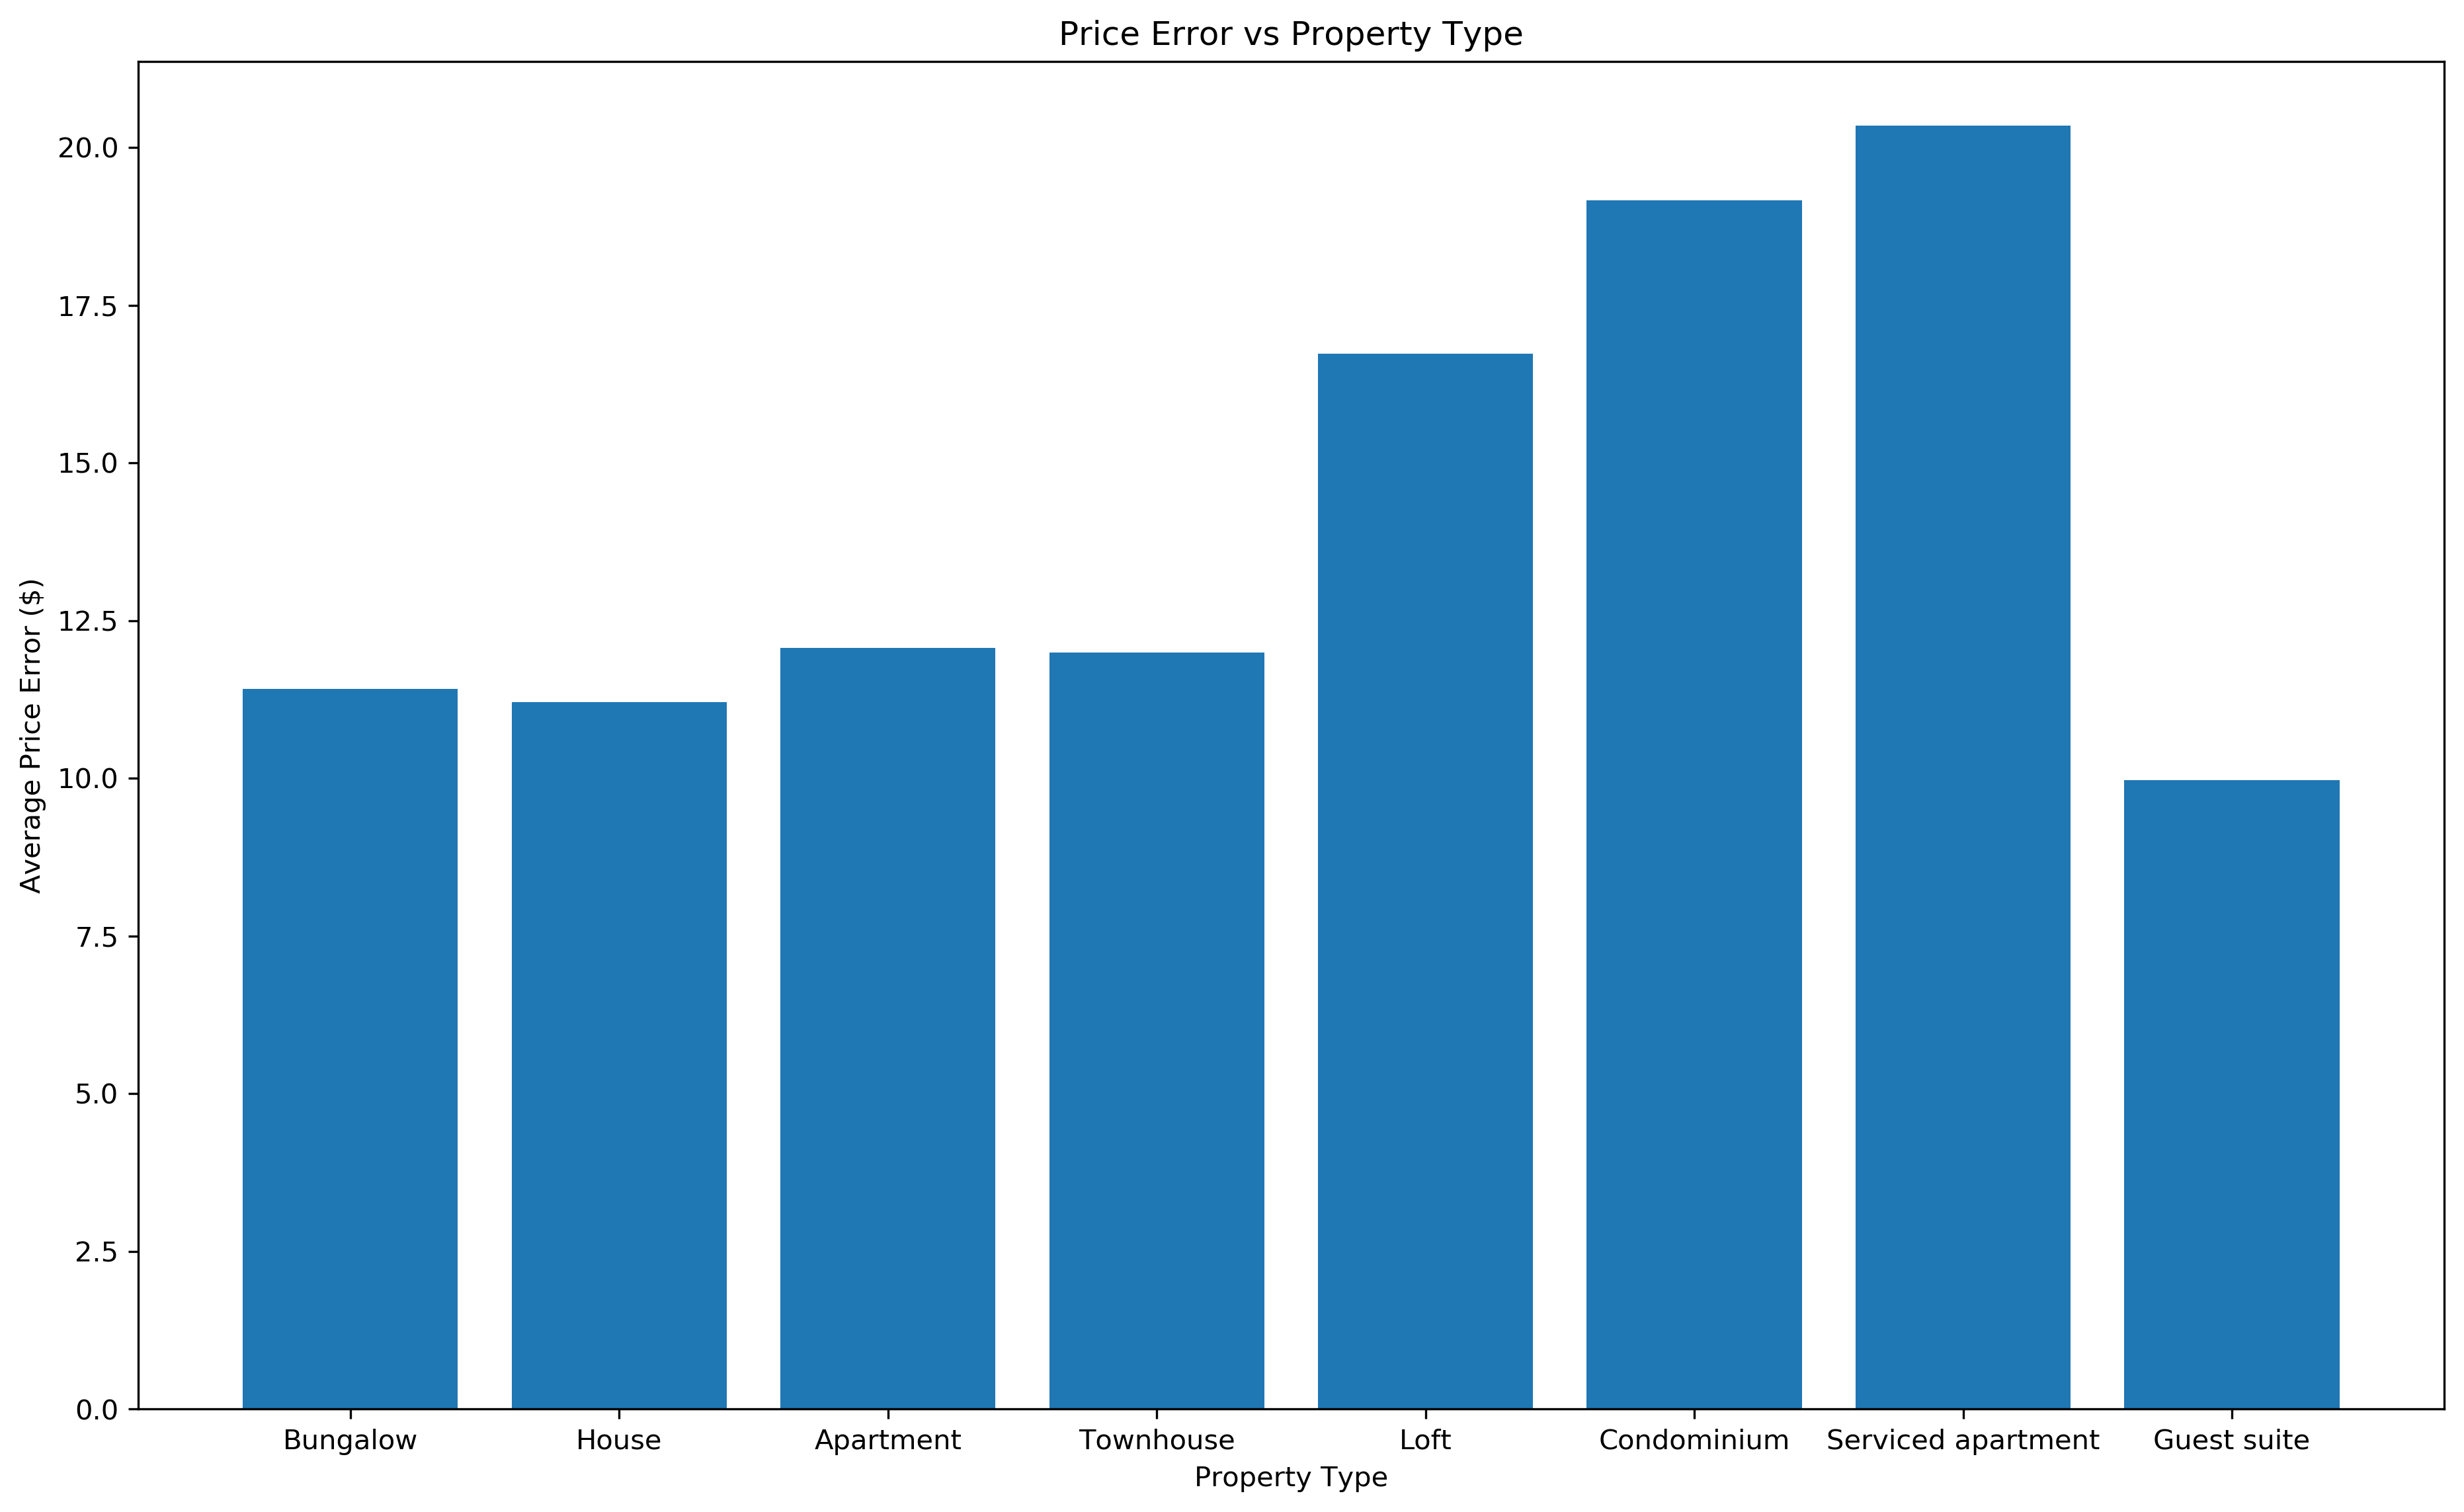

<Figure size 4500x1800 with 0 Axes>

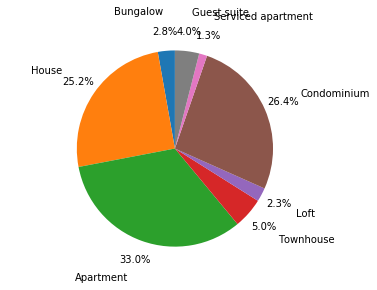

In [10]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 8)]
    num_samples = [0 for i in range(0, 8)]
    x_plot = [-4.440892098500626e-16, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    
    error_to_plot = [0 for i in range(0, 8)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        property_type = data["property_type"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(property_type.item())
        
        for k in range(len(num_samples)):
            if (property_type.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    plt.figure(num=None, figsize=(15, 9), dpi=300, facecolor='w', edgecolor='k')
    plt.bar(['Bungalow', 'House', 'Apartment', 'Townhouse', 'Loft', 'Condominium', 'Serviced apartment', 'Guest suite'], 
            error_to_plot)
    plt.xlabel("Property Type")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Property Type")
    
    
    plt.savefig("../live_demo/Price_Error_vs_Property_Type.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    percent = [0 for i in range(0,8)]
    
    for i in range(0, len(percent)):
        percent[i] = float(num_samples[i])/float(len(blah))
    
    plt.figure(num=None, figsize=(15, 6), dpi=300, facecolor='w', edgecolor='k')
    
    labels = 'Bungalow', 'House', 'Apartment', 'Townhouse', 'Loft', 'Condominium', 'Serviced apartment', 'Guest suite'

    fig1, ax1 = plt.subplots()
    ax1.pie(percent, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=1.2, labeldistance=1.4, radius=50.0)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.savefig("../live_demo/Price_Error_vs_Property_Type_PIE2.png", dpi=300)

    

get_errorNew(model, test_loader, [10, 20, 30])

# Room Type

None
[0.0, 1.0, 2.0]


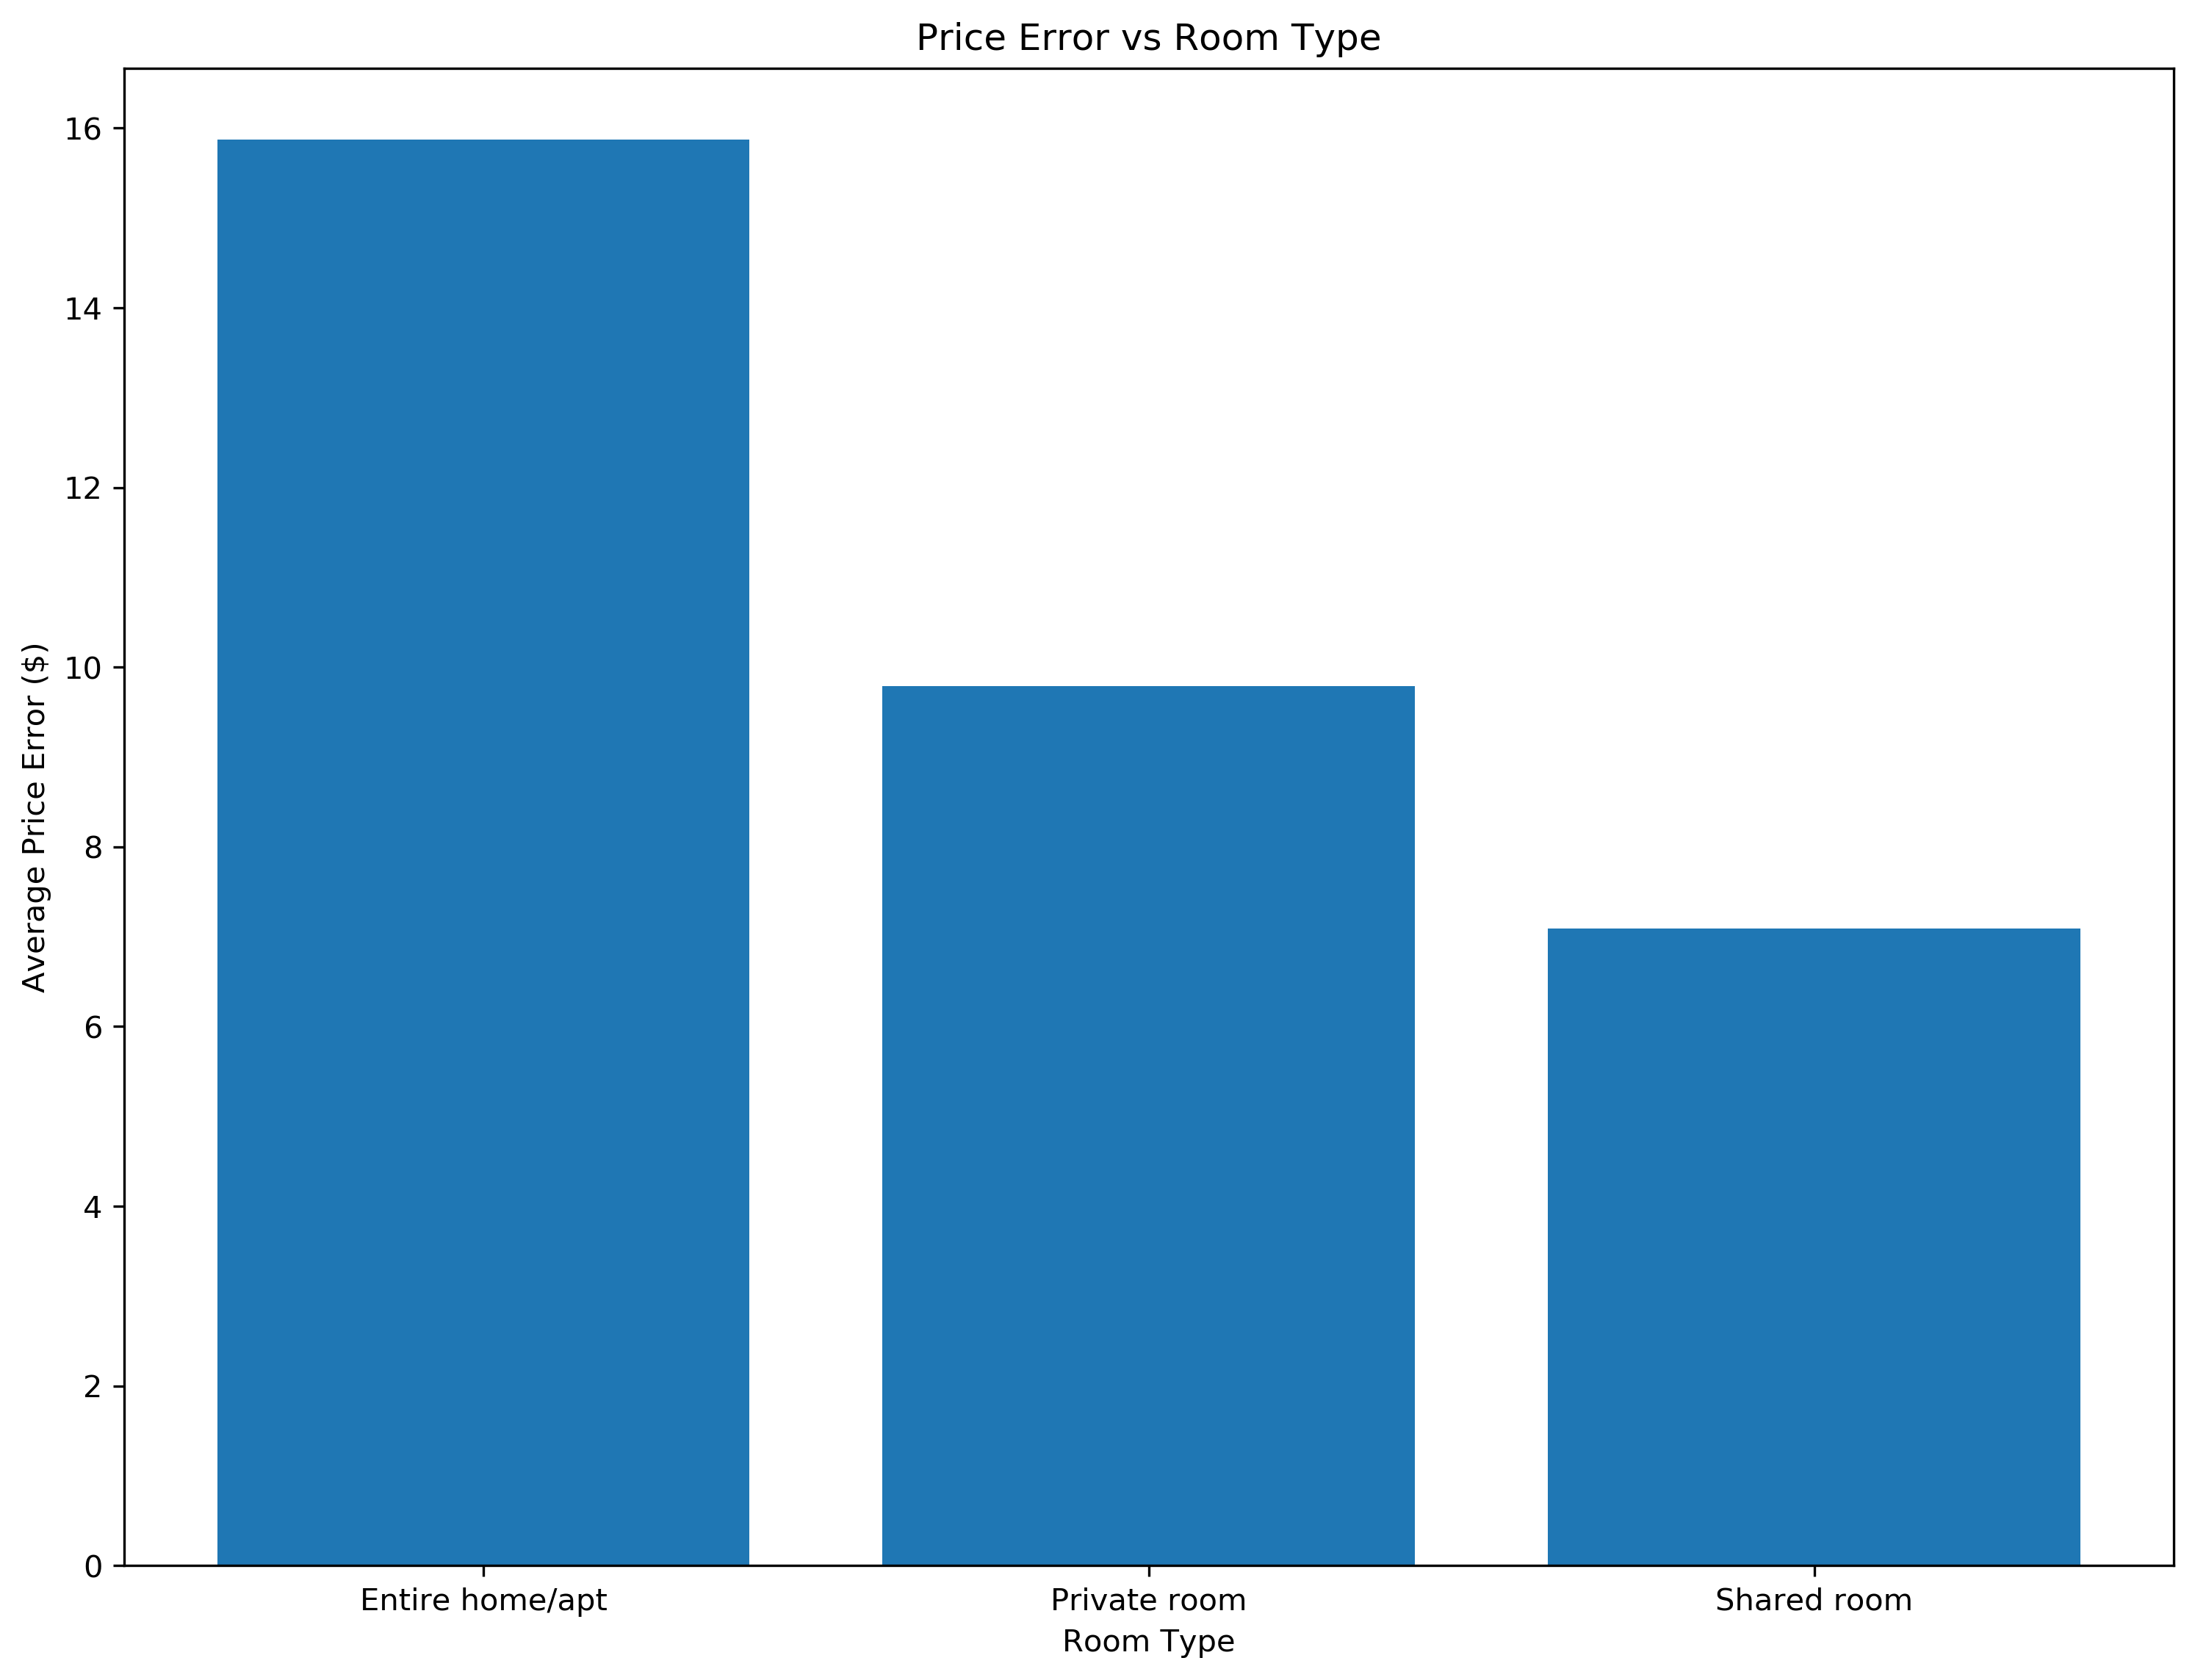

<Figure size 4500x1800 with 0 Axes>

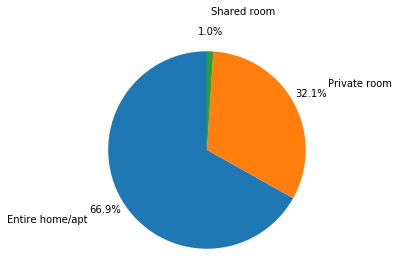

In [12]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 3)]
    num_samples = [0 for i in range(0, 3)]
    x_plot = [0.0, 1.0, 2.0]
    
    error_to_plot = [0 for i in range(0, 3)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        room_type = data["room_type"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(room_type.item())
        
        for k in range(len(num_samples)):
            if (room_type.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    plt.figure(num=None, figsize=(12, 9), dpi=300, facecolor='w', edgecolor='k')
    plt.bar(['Entire home/apt', 'Private room', 'Shared room'], 
            error_to_plot)
    plt.xlabel("Room Type")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Room Type")
    
    
    plt.savefig("../live_demo/Price_Error_vs_Room_Type.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    percent = [0 for i in range(0,3)]
    
    for i in range(0, len(percent)):
        percent[i] = float(num_samples[i])/float(len(blah))
    
    plt.figure(num=None, figsize=(15, 6), dpi=300, facecolor='w', edgecolor='k')
    
    labels = 'Entire home/apt', 'Private room', 'Shared room'

    fig1, ax1 = plt.subplots()
    ax1.pie(percent, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=1.2, labeldistance=1.4, radius=50.0)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.savefig("../live_demo/Price_Error_vs_Room_Type_PIE2.png", dpi=300)

    

get_errorNew(model, test_loader, [10, 20, 30])

# Price Error vs Accommodates

In [280]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    
    error_analysis = [0 for i in range(0, 16)]
    num_samples = [0 for i in range(0, 16)]
    x_plot = [(i+1) for i in range(0, 16)]
    
    error_to_plot = [0 for i in range(0, 16)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        accommodates = data["accommodates"].float()

        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        for k in range(len(num_samples)):
            if (accommodates.item() == (k+1)):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #print(error_to_plot)
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of People Accommodated")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of People Accommodated")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    #plt.show()
    
    plt.savefig("../live_demo/Price_Error_vs_Accomodates.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

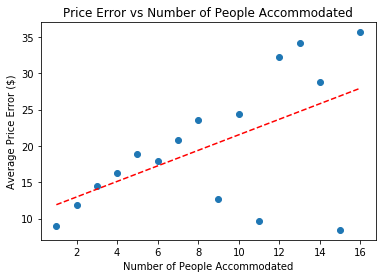

In [281]:
get_errorNew(model, test_loader, [10, 20, 30])

# Number of Bathrooms 

(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

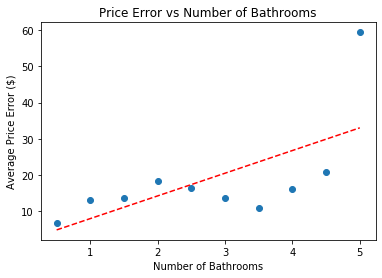

In [275]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    
    error_analysis = [0 for i in range(0, 10)]
    num_samples = [0 for i in range(0, 10)]
    x_plot = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
    
    error_to_plot = [0 for i in range(0, 10)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        accommodates = data["accommodates"].float()
        bathrooms = data["bathrooms"].float()
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        
        for k in range(len(num_samples)):
            if (bathrooms.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
    
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of Bathrooms")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of Bathrooms")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_Bathrooms.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

# Number of Bedrooms

(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

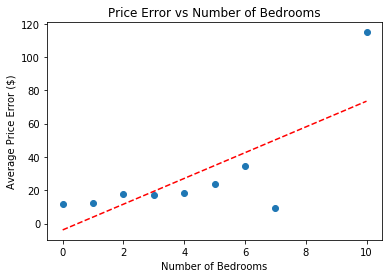

In [276]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 9)]
    num_samples = [0 for i in range(0, 9)]
    x_plot = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0]
    
    error_to_plot = [0 for i in range(0, 9)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        bedrooms = data["bedrooms"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        
        for k in range(len(num_samples)):
            if (bedrooms.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
    
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of Bedrooms")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of Bedrooms")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_Bedrooms.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

# Number of Beds

None
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0]


(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

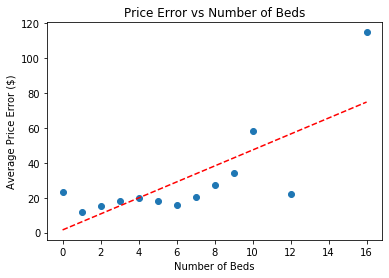

In [277]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 13)]
    num_samples = [0 for i in range(0, 13)]
    x_plot = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0]
    
    error_to_plot = [0 for i in range(0, 13)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        beds = data["beds"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(beds.item())
        
        for k in range(len(num_samples)):
            if (beds.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of Beds")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of Beds")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_Beds.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

# Number of Amenities

None
[-3.552713678800501e-15, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

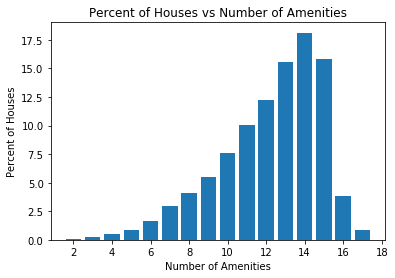

In [21]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 16)]
    num_samples = [0 for i in range(0, 16)]
    x_plot = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
    
    error_to_plot = [0 for i in range(0, 16)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        amenities_count = data["amenities_count"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(amenities_count.item())
        
        for k in range(len(num_samples)):
            if (amenities_count.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    '''
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of Amenities")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of Amenities")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_Amenities.png", dpi=300)
    '''
    
    plt.bar(x_plot, [((num_samples[i]/sum(num_samples))*100) for i in range (0,len(num_samples))])
    plt.xlabel("Number of Amenities")
    plt.ylabel("Percent of Houses")
    plt.title("Percent of Houses vs Number of Amenities")
    
    plt.savefig("../live_demo/House_Percent_vs_Number_of_Amenities.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

# Number of Facilities

None
[-2.220446049250313e-16, 1.0, 2.0, 3.0, 4.0]


(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

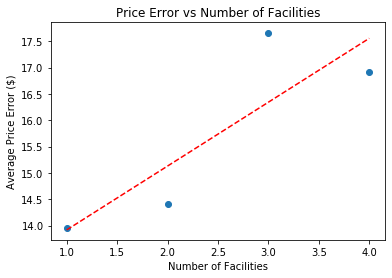

In [286]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 4)]
    num_samples = [0 for i in range(0, 4)]
    x_plot = [1.0, 2.0, 3.0, 4.0]
    
    error_to_plot = [0 for i in range(0, 4)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        facilities_count = data["facilities_count"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(facilities_count.item())
        
        for k in range(len(num_samples)):
            if (facilities_count.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of Facilities")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of Facilities")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_Facilities.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

# Number of House Rules

None
[0.0, 1.0, 2.0, 3.0]


(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

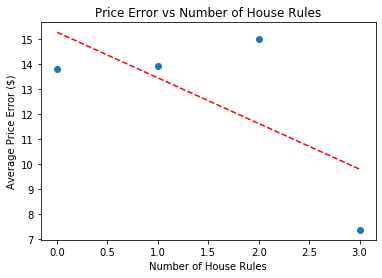

In [285]:
def get_errorNew(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    blah = []
    
    error_analysis = [0 for i in range(0, 4)]
    num_samples = [0 for i in range(0, 4)]
    x_plot = [0.0, 1.0, 2.0, 3.0]
    
    error_to_plot = [0 for i in range(0, 4)]
    
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        house_rules_count = data["house_rules_count"].float()
        
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
            
        blah.append(house_rules_count.item())
        
        for k in range(len(num_samples)):
            if (house_rules_count.item() == x_plot[k]):
                num_samples[k] += 1
                error_analysis[k] += error.sum().item()
        
        train_samples += len(label)
        train_error += error.sum().item()
    
    for l in range(len(num_samples)):
        if(num_samples[l] != 0):
            error_to_plot[l] = float(error_analysis[l])/float(num_samples[l])
        else:
            error_to_plot[l] = 0.0
            
    #'''
    myset = set(blah)
    mynewlist = list(myset)
    print(mynewlist.sort())
    print(mynewlist)
    #'''
    
    plt.scatter(x_plot, error_to_plot)
    plt.xlabel("Number of House Rules")
    plt.ylabel("Average Price Error ($)")
    plt.title("Price Error vs Number of House Rules")
    
    z = np.polyfit(x_plot, error_to_plot, 1)
    p = np.poly1d(z)
    plt.plot(x_plot, p(x_plot),"r--")
    
    plt.savefig("../live_demo/Price_Error_vs_Number_of_House_Rules.png", dpi=300)
    
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

get_errorNew(model, test_loader, [10, 20, 30])

In [7]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*3)
        self.layer2 = nn.Linear(41*3, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*2)
        self.layer5 = nn.Linear(41*2, 41*1)
        self.layer6 = nn.Linear(41*1, 1)
        
        
        #self.dropout2 = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer5(x))
        return self.layer6(x)

In [8]:
model = airbnb_net()
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.accom = torch.from_numpy(df["accommodates"].to_numpy())
        self.bath = torch.from_numpy(df["bathrooms"].to_numpy())
        self.bedroom = torch.from_numpy(df["bedrooms"].to_numpy())
        self.bed = torch.from_numpy(df["beds"].to_numpy())
        self.amen = torch.from_numpy(df["amenities_count"].to_numpy())
        self.facility = torch.from_numpy(df["facilities_count"].to_numpy())
        self.house_rules = torch.from_numpy(df["house_rules_count"].to_numpy())
        self.property = torch.from_numpy(df["property_type"].to_numpy())
        self.room = torch.from_numpy(df["room_type"].to_numpy())
        
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        accommodates = (self.accom[index]*mean_std["std"]["accommodates"]) + mean_std["mean"]["accommodates"]
        bathrooms = (self.bath[index]*mean_std["std"]["bathrooms"]) + mean_std["mean"]["bathrooms"]
        bedrooms = (self.bedroom[index]*mean_std["std"]["bedrooms"]) + mean_std["mean"]["bedrooms"]
        beds = (self.bed[index]*mean_std["std"]["beds"]) + mean_std["mean"]["beds"]
        amenities_count = (self.amen[index]*mean_std["std"]["amenities_count"]) + mean_std["mean"]["amenities_count"]
        facilities_count = (self.facility[index]*mean_std["std"]["facilities_count"]) + mean_std["mean"]["facilities_count"]
        house_rules_count = (self.house_rules[index]*mean_std["std"]["house_rules_count"]) + mean_std["mean"]["house_rules_count"]
        property_type = (self.property[index]*mean_std["std"]["property_type"]) + mean_std["mean"]["property_type"]
        room_type = (self.room[index]*mean_std["std"]["room_type"]) + mean_std["mean"]["room_type"]
        
        return {"sample": sample, "label": label, "accommodates": accommodates, "bathrooms": bathrooms, 
                "bedrooms": bedrooms, "beds": beds, "amenities_count": amenities_count, 
                "facilities_count": facilities_count, "house_rules_count": house_rules_count, 
               "property_type": property_type, "room_type": room_type}
        
        #return {"sample": sample, "label": label}
#print(test_df)
    

test_ds = airbnb_dataset(test_df, "test")
demo_ds = airbnb_dataset(demo_df, "demo")

demo_loader = DataLoader(demo_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [323]:
get_error(model, test_loader, [10, 20, 30])

(13.830391638213136,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

In [138]:
get_error(model, demo_loader, [10, 20, 30])

(30.421612548828126, [0.2, 0.5, 0.6])

In [137]:
for i, data in enumerate(demo_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = model(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        
print(error)

tensor([  6.4790,  13.4228,   6.2919,  22.7608,  45.1961,  18.6180,  31.2840,
         10.2982, 117.2158,  32.6497], grad_fn=<MulBackward0>)
